Factorization machines model feature interactions in a linear paradigm (e.g., bilinear interactions). This is often insufficient for real-world data where inherent feature crossing structures are usually very complex and nonlinear.

One effective solution is using deep neural networks. Deep neural networks are powerful in feature representation learning and have the potential to learn sophisticated feature interactions.

### Model Architectures

Let $\mathbf{e}_i \in \mathbb{R}^{k}$ denote the latent feature vector of the $i^\mathrm{th}$ field.

The input of the deep component is the concatenation of the dense embeddings of all fields. $\mathbf{z}^{(0)}  = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_f]$, where $f$ is the number of fields. It is then fed into the following neural network: $\mathbf{z}^{(l)}  = \alpha(\mathbf{W}^{(l)}\mathbf{z}^{(l-1)} + \mathbf{b}^{(l)})$

So we have: $\hat{y} = \sigma(\hat{y}^{(FM)} + \hat{y}^{(DNN)})$

<img src="https://classic.d2l.ai/_images/rec-deepfm.svg" />

In [ ]:
!pip install mxnet-cu101==1.7.0

In [ ]:
!pip install d2l==0.17.5

In [1]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Implemenation of DeepFM

In [2]:
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

### Training and Evaluating the Model

loss 0.509, train acc 0.424, test acc 0.420
92846.4 examples/sec on [gpu(0)]


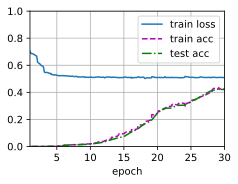

In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)